In [1]:
# OLD BIRD

import numpy as np
import os
import pandas as pd
import sys
sys.path.append("../src")
import localmodule

dataset_name = localmodule.get_dataset_name()
models_dir = localmodule.get_models_dir()
units = localmodule.get_units()
n_units = len(units)
models_dir = localmodule.get_models_dir()
model_name = "oldbird"
model_dir = os.path.join(models_dir, model_name)
units = localmodule.get_units()
tolerance_ms = 500
tol_str = "tol-" + str(tolerance_ms)
prefix = "_".join([dataset_name, "oldbird_merged_clip-suppressor"])
n_thresholds = 100

unit_relevant = []
unit_selected, unit_tp = [], []

tp_matrix = np.zeros((n_thresholds, n_units))
fp_matrix = np.zeros((n_thresholds, n_units))
fn_matrix = np.zeros((n_thresholds, n_units))

for unit_id, unit_str in enumerate(units):
    unit_dir = os.path.join(model_dir, unit_str)
    metrics_name = "_".join([prefix, unit_str, tol_str, "metrics"])
    metrics_path = os.path.join(unit_dir, metrics_name + ".csv")
    df = pd.read_csv(metrics_path)
    true_positives = np.array(df["True positives"])
    tp_matrix[:, unit_id] = true_positives
    false_positives = np.array(df["False positives"])
    fp_matrix[:, unit_id] = false_positives
    false_negatives = np.array(df["False negatives"])
    fn_matrix[:, unit_id] = false_negatives
    
    
oldbird_tp = np.sum(tp_matrix, axis=1)
oldbird_fp = np.sum(fp_matrix, axis=1)
oldbird_fn = np.sum(fn_matrix, axis=1)

eps = np.finfo(float).eps
oldbird_precisions = oldbird_tp / (eps+oldbird_tp+oldbird_fp)
oldbird_recalls = oldbird_tp / (eps+oldbird_tp+oldbird_fn)

sorting_indices = np.argsort(oldbird_recalls)
oldbird_precisions = oldbird_precisions[sorting_indices]
oldbird_recalls = oldbird_recalls[sorting_indices]

oldbird_f1_scores = 2*oldbird_precisions*oldbird_recalls / (eps+oldbird_precisions+oldbird_recalls)

In [2]:
# SPECTRAL FLUX
import h5py
import mir_eval
import numpy as np
import os
import pandas as pd
import peakutils
import sys
from tqdm import tqdm
sys.path.append('../src')
import localmodule


# Define directory of spectral flux ODFs.
data_dir = localmodule.get_data_dir()
dataset_name = localmodule.get_dataset_name()
units = localmodule.get_units()
n_units = len(units)
sf_dir = os.path.join(data_dir,
    "_".join([dataset_name, "spectral-flux"]))


# Define constants.
sf_sr = 22050
sf_hop_length = 512
n_thresholds = 100
min_dist = 4
tolerance = 0.5


# Define array of thresholds.
thresholds = np.linspace(0.0, 0.5, n_thresholds)


# Define directory for annotations.
annotations_name = "_".join([dataset_name, "annotations"])
annotations_dir = os.path.join(data_dir, annotations_name)


tp_matrix = np.zeros((n_thresholds, n_units))
fp_matrix = np.zeros((n_thresholds, n_units))
fn_matrix = np.zeros((n_thresholds, n_units))


# Loop over units.
for unit_id, unit_str in enumerate(units):

    # Load onset detection function.
    odf_path = os.path.join(sf_dir, unit_str + ".hdf5")
    odf_file = h5py.File(odf_path, "r")
    odf = odf_file["spectral-flux_odf"].value
    odf = np.ravel(odf)
    odf_file.close()

    # Load annotation.
    annotation_path = os.path.join(
        annotations_dir, unit_str + ".txt")
    annotation = pd.read_csv(annotation_path, '\t')
    begin_times = np.array(annotation["Begin Time (s)"])
    end_times = np.array(annotation["End Time (s)"])
    relevant = 0.5 * (begin_times + end_times)
    relevant = np.sort(relevant)
    n_relevant = len(relevant)

    # Loop over thresholds.
    for th_id, threshold in tqdm(enumerate(thresholds)):
        # Pick peaks.
        peak_locs = peakutils.indexes(
            odf, thres=threshold, min_dist=4)
        selected = peak_locs * sf_hop_length / sf_sr
        selected_relevant = mir_eval.util.match_events(
            relevant, selected, tolerance)
        
        true_positives = len(selected_relevant)
        n_selected = len(selected)
        false_positives = n_selected - true_positives
        false_negatives = n_relevant - true_positives

        tp_matrix[th_id, unit_id] = true_positives
        fp_matrix[th_id, unit_id] = false_positives
        fn_matrix[th_id, unit_id] = false_negatives
        
sf_total_tps = np.sum(tp_matrix, axis=1)
sf_total_fps = np.sum(fp_matrix, axis=1)
sf_total_fns = np.sum(fn_matrix, axis=1)

sf_total_precisions = 100.0 * sf_total_tps / (sf_total_tps + sf_total_fps)
sf_total_precisions = sf_total_precisions[::-1]
sf_total_recalls = 100.0 * sf_total_tps / (sf_total_tps + sf_total_fns)
sf_total_recalls = sf_total_recalls[::-1]
sf_total_f1_scores = (2*sf_total_precisions*sf_total_recalls) / (sf_total_precisions+sf_total_recalls)

100it [00:27,  3.61it/s]
100it [00:14,  6.71it/s]
100it [00:23,  4.17it/s]
100it [00:25,  3.91it/s]
100it [00:25, 22.39it/s]
100it [00:09, 10.71it/s]


In [3]:
# CONVNET

import numpy as np
import os
import pandas as pd
import scipy.interpolate
import sklearn.metrics
import sys
sys.path.append("../src")
import localmodule


from matplotlib import pyplot as plt
%matplotlib inline

# Define constants.
dataset_name = localmodule.get_dataset_name()
models_dir = localmodule.get_models_dir()
units = localmodule.get_units()
n_units = len(units)
n_thresholds = 221
n_trials = 10
n_eval_trials = 5


# Initialize dicts.
report = {}


# Loop over augmentations.
for aug_kind_str in ["none", "all"]:

    # Initialize dictionaries
    aug_report = {
        "validation": {},
        "test-CV-AUPRC": {},
        "test-CV-F": {},
        "test-oracle-AUPRC": {},
        "test-oracle-F": {},
    }


    val_precisions = np.zeros((n_units, n_trials))
    val_recalls = np.zeros((n_units, n_trials))
    val_f1_scores = np.zeros((n_units, n_trials))
    val_auprcs = np.zeros((n_units, n_trials))
    val_thresholds = np.zeros((n_units, n_trials))
    val_threshold_ids = np.zeros((n_units, n_trials))


    thresholds = 1.0 - np.concatenate((
        np.logspace(-9, -2, 141), np.delete(np.logspace(-2, 0, 81), 0)
    ))
    n_thresholds = len(thresholds)


    # Define model directory
    model_name = "icassp-convnet"
    if not aug_kind_str == "none":
        model_name = "_".join([model_name, "aug-" + aug_kind_str])
    model_dir = os.path.join(models_dir, model_name)


    # Loop over test units.
    for test_unit_id in range(n_units):

        test_unit_str = units[test_unit_id]
        test_unit_dir = os.path.join(model_dir, test_unit_str)

        # Retrieve fold such that unit_str is in the test set.
        folds = localmodule.fold_units()
        fold = [f for f in folds if test_unit_str in f[0]][0]
        test_units = fold[0]
        validation_units = fold[2]

        # Loop over trials.
        for trial_id in range(n_trials):

            trial_str = "trial-" + str(trial_id)
            trial_dir = os.path.join(test_unit_dir, trial_str)
            break_switch = False

            # Loop over validation units.
            for predict_unit_str in validation_units:
                val_metrics_name = "_".join([
                    dataset_name,
                    model_name,
                    "test-" + test_unit_str,
                    trial_str,
                    "predict-" + predict_unit_str,
                    "full-audio-metrics.csv"
                ])
                val_metrics_path = os.path.join(trial_dir, val_metrics_name)
                val_tp = np.zeros((n_thresholds,))
                val_fp = np.zeros((n_thresholds,))
                val_fn = np.zeros((n_thresholds,))
                try:
                    val_metrics_df = pd.read_csv(val_metrics_path)
                    val_tp = val_tp + np.array(val_metrics_df["True positives"])
                    val_fp = val_fp + np.array(val_metrics_df["False positives"])
                    val_fn = val_fn + np.array(val_metrics_df["False negatives"])
                except:
                    break_switch = True
                    break

            if break_switch:
                val_auprc = 0.0
                val_p = np.zeros((n_thresholds,))
                val_r = np.zeros((n_thresholds,))
                val_f = np.zeros((n_thresholds,))
                val_threshold_id = 0
            else:
                val_p = val_tp / (np.finfo(float).eps + val_tp + val_fp)
                val_r = val_tp / (np.finfo(float).eps + val_tp + val_fn)
                val_f = 2*val_p*val_r / (np.finfo(float).eps+(val_p+val_r))
                val_threshold_id = np.argmax(val_f)
                val_p_ = np.array([1.0] + list(val_p) + [0.0])
                val_r_ = np.array([0.0] + list(val_r) + [1.0])
                val_auprc = sklearn.metrics.auc(val_r_, val_p_, reorder=True)

            val_precisions[test_unit_id, trial_id] = val_p[val_threshold_id]
            val_recalls[test_unit_id, trial_id] = val_r[val_threshold_id]
            val_f1_scores[test_unit_id, trial_id] = val_f[val_threshold_id]
            val_thresholds[test_unit_id, trial_id] = thresholds[val_threshold_id]
            val_threshold_ids[test_unit_id, trial_id] = val_threshold_id
            val_auprcs[test_unit_id, trial_id] = val_auprc


    aug_report["validation"]["P"] = val_precisions
    aug_report["validation"]["R"] = val_recalls
    aug_report["validation"]["F"] = val_f1_scores
    aug_report["validation"]["AUPRC"] = val_auprcs
    aug_report["validation"]["threshold"] = val_thresholds
    aug_report["validation"]["threshold_ids"] = val_threshold_ids
    aug_report["validation"]["trials_F"] = np.argsort(val_f1_scores, axis=1)
    aug_report["validation"]["trials_AUPRC"] = np.argsort(val_auprcs, axis=1)


    # Loop over test trials.
    auprc_eval_trials = np.sort(aug_report["validation"]["trials_AUPRC"][:, -5:], axis=1)
    test_auprcs = np.zeros((n_eval_trials,))
    test_precisions = np.zeros((n_thresholds, n_eval_trials))
    test_recalls = np.zeros((n_thresholds, n_eval_trials))
    test_f1_scores = np.zeros((n_thresholds, n_eval_trials))

    for eval_trial_id in range(n_eval_trials):
        test_tp = np.zeros((n_thresholds,))
        test_fp = np.zeros((n_thresholds,))
        test_fn = np.zeros((n_thresholds,))

        for test_unit_id in range(n_units):
            test_unit_str = units[test_unit_id]
            test_unit_dir = os.path.join(model_dir, test_unit_str)
            trial_id = auprc_eval_trials[test_unit_id, eval_trial_id]
            trial_str = "trial-" + str(trial_id)
            trial_dir = os.path.join(test_unit_dir, trial_str)

            # Load test predictions.
            test_metrics_name = "_".join([
                dataset_name,
                model_name,
                "test-" + test_unit_str,
                trial_str,
                "predict-" + test_unit_str,
                "full-audio-metrics.csv"
            ])
            test_metrics_path = os.path.join(trial_dir, test_metrics_name)
            test_metrics_df = pd.read_csv(test_metrics_path)
            test_tp = test_tp + np.array(test_metrics_df["True positives"])
            test_fp = test_fp + np.array(test_metrics_df["False positives"])
            test_fn = test_fn + np.array(test_metrics_df["False negatives"])

        test_p = test_tp / (np.finfo(float).eps + test_tp + test_fp)
        test_r = test_tp / (np.finfo(float).eps + test_tp + test_fn)
        test_p_ = np.array([1.0] + list(test_p) + [0.0])
        test_r_ = np.array([0.0] + list(test_r) + [1.0])
        test_auprc = sklearn.metrics.auc(test_r_, test_p_, reorder=True)

        test_auprcs[eval_trial_id] = test_auprc
        test_precisions[:, eval_trial_id] = test_p
        test_recalls[:, eval_trial_id] = test_r
        test_f1_scores[:, eval_trial_id] =\
            (2*test_p*test_r) / (np.finfo(float).eps+test_p+test_r)


    aug_report["test-CV-AUPRC"]["AUPRC"] = test_auprcs
    aug_report["test-CV-AUPRC"]["P"] = test_precisions
    aug_report["test-CV-AUPRC"]["R"] = test_recalls
    aug_report["test-CV-AUPRC"]["F"] = test_f1_scores


    all_test_recalls = np.array(list(np.sort(np.ravel(test_recalls))))
    interpolated_precisions = np.zeros((2 + len(all_test_recalls), n_eval_trials))

    for eval_trial_id in range(n_eval_trials):
        precision_interpolator = scipy.interpolate.interp1d(
            np.array([0.0] + list(test_recalls[:, eval_trial_id]) + [1.0]),
            np.array([1.0] + list(test_precisions[:, eval_trial_id]) + [1.0]))
        interpolated_precisions[:, eval_trial_id] =\
            np.array([1.0] + list(precision_interpolator(all_test_recalls)) + [0.0])

    interpolated_recalls = np.array([0.0] + list(all_test_recalls) + [1.0])
    aug_report["test-CV-AUPRC"]["interpolated_P"] = np.sort(interpolated_precisions, axis=1)
    aug_report["test-CV-AUPRC"]["interpolated_R"] = interpolated_recalls
    aug_report["test-CV-AUPRC"]["interpolated_F"] =\
        (2*aug_report["test-CV-AUPRC"]["interpolated_P"]*aug_report["test-CV-AUPRC"]["interpolated_R"][:, np.newaxis]) /\
        (aug_report["test-CV-AUPRC"]["interpolated_P"]+aug_report["test-CV-AUPRC"]["interpolated_R"][:, np.newaxis])


    # Estimate F1 score.
    f_eval_trials = np.sort(aug_report["validation"]["trials_F"][:, -5:], axis=1)
    test_precisions = np.zeros((n_eval_trials,))
    test_recalls = np.zeros((n_eval_trials,))
    test_f1_scores = np.zeros((n_eval_trials,))

    for eval_trial_id in range(n_eval_trials):
        test_tp = 0
        test_fp = 0
        test_fn = 0

        for test_unit_id in range(n_units):
            test_unit_str = units[test_unit_id]
            test_unit_dir = os.path.join(model_dir, test_unit_str)
            trial_id = f_eval_trials[test_unit_id, eval_trial_id]
            trial_str = "trial-" + str(trial_id)
            trial_dir = os.path.join(test_unit_dir, trial_str)
            
            threshold_id = int(aug_report["validation"]["threshold_ids"][
                test_unit_id, trial_id])

            # Load test predictions.
            test_metrics_name = "_".join([
                dataset_name,
                model_name,
                "test-" + test_unit_str,
                trial_str,
                "predict-" + test_unit_str,
                "full-audio-metrics.csv"
            ])
            test_metrics_path = os.path.join(trial_dir, test_metrics_name)
            test_metrics_df = pd.read_csv(test_metrics_path)
            test_tp = test_tp + np.array(test_metrics_df["True positives"])[threshold_id]
            test_fp = test_fp + np.array(test_metrics_df["False positives"])[threshold_id]
            test_fn = test_fn + np.array(test_metrics_df["False negatives"])[threshold_id]

        test_p = test_tp / (np.finfo(float).eps + test_tp + test_fp)
        test_r = test_tp / (np.finfo(float).eps + test_tp + test_fn)
        test_f = 2*test_p*test_r / (np.finfo(float).eps+test_p+test_r)

        test_precisions[eval_trial_id] = test_p
        test_recalls[eval_trial_id] = test_r
        test_f1_scores[eval_trial_id] =\
            (2*test_p*test_r) / (np.finfo(float).eps+test_p+test_r)
            
    aug_report["test-CV-F"]["P"] = test_precisions
    aug_report["test-CV-F"]["R"] = test_recalls
    aug_report["test-CV-F"]["F"] = test_f1_scores
    
    report[aug_kind_str] = aug_report

In [16]:
np.mean(np.sort(report["all"]["validation"]["AUPRC"], axis=1)[:, -5:], axis=1)

array([ 0.67929575,  0.66599852,  0.56106717,  0.77257389,  0.46501297,
        0.8603874 ])

In [6]:
report["all"]["test-CV-AUPRC"]

{'AUPRC': array([ 0.584095  ,  0.63561248,  0.6339047 ,  0.62212594,  0.63773739]),
 'F': array([[ 0.35295597,  0.42790717,  0.34734553,  0.38978859,  0.46430929],
        [ 0.35295597,  0.42790717,  0.34734553,  0.38978859,  0.46430929],
        [ 0.35295597,  0.42790717,  0.34734553,  0.38978859,  0.46430929],
        ..., 
        [ 0.11722689,  0.12112152,  0.11181427,  0.11352741,  0.11617216],
        [ 0.1094169 ,  0.10481815,  0.10266519,  0.10070289,  0.10740003],
        [ 0.08213971,  0.08110349,  0.081202  ,  0.08133519,  0.08134013]]),
 'P': array([[ 0.68611949,  0.85188925,  0.87925697,  0.81890475,  0.86289395],
        [ 0.68611949,  0.85188925,  0.87925697,  0.81890475,  0.86289395],
        [ 0.68611949,  0.85188925,  0.87925697,  0.81890475,  0.86289395],
        ..., 
        [ 0.0624635 ,  0.06466246,  0.05938754,  0.06034093,  0.06186434],
        [ 0.05803582,  0.05543977,  0.05423996,  0.05313929,  0.05689826],
        [ 0.04289825,  0.04233346,  0.04238703,  0.

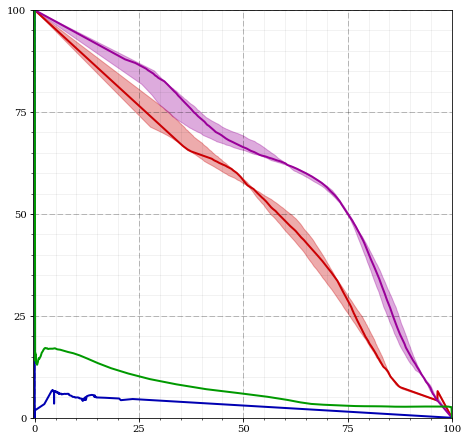

In [79]:
from matplotlib import pyplot as plt
sorted_precisions = np.sort(interpolated_precisions, axis=1)

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(7.5, 7.5))


ax.fill_between(
    100 * report["none"]["test-CV-AUPRC"]["interpolated_R"],
    100 * report["none"]["test-CV-AUPRC"]["interpolated_P"][:, 1],
    100 * report["none"]["test-CV-AUPRC"]["interpolated_P"][:, 3],
    color = "#CB0003",
    alpha = 0.33);

ax.plot(
    100 * report["none"]["test-CV-AUPRC"]["interpolated_R"],
    100 * report["none"]["test-CV-AUPRC"]["interpolated_P"][:, 2],
    color = "#CB0003",
    linewidth = 2.0
)

ax.fill_between(
    100 * report["all"]["test-CV-AUPRC"]["interpolated_R"],
    100 * report["all"]["test-CV-AUPRC"]["interpolated_P"][:, 1],
    100 * report["all"]["test-CV-AUPRC"]["interpolated_P"][:, 3],
    color = "#990099",
    alpha = 0.33);

ax.plot(
    100 * report["all"]["test-CV-AUPRC"]["interpolated_R"],
    100 * report["all"]["test-CV-AUPRC"]["interpolated_P"][:, 2],
    color = "#990099",
    linewidth = 2.0
)

ax.plot(
    [0.0] + list(100 * oldbird_recalls) + [100.0],
    [100.0] + list(100 * oldbird_precisions) + [0.0],
    color = "#0000B2",
    linewidth = 2.0)

ax.plot(
    [0.0] + list(sf_total_recalls) + [100.0],
    [100.0] + list(sf_total_precisions) + [0.0],
    color = "#009900",
    linewidth = 2.0)

major_ticks = np.linspace(0, 100, 5).astype("int")
minor_ticks = np.linspace(0, 100, 21).astype("int")

ax.set_xlim(-0.3, 100)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_xticklabels(map(str, major_ticks), family="serif");

ax.set_ylim(0.0, 100)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.set_yticklabels(map(str, major_ticks), family="serif");

ax.grid(color='k', linestyle='--', linewidth=1.0, alpha=0.25, which="major")
ax.grid(color='k', linestyle='-', linewidth=0.5, alpha=0.1, which="minor")

plt.savefig("fig_precision-recall.png", dpi=900)

In [66]:
major_ticks

array([  0,  25,  50,  75, 100])

In [4]:
none_cv_p = report["none"]["test-CV-F"]["P"]
none_cv_r = report["none"]["test-CV-F"]["R"]
none_cv_f = report["none"]["test-CV-F"]["F"]
none_cv_auprc = report["none"]["test-CV-AUPRC"]["AUPRC"]

all_cv_p = report["all"]["test-CV-F"]["P"]
all_cv_r = report["all"]["test-CV-F"]["R"]
all_cv_f = report["all"]["test-CV-F"]["F"]
all_cv_auprc = report["all"]["test-CV-AUPRC"]["AUPRC"]

print("      P = {:5.2f}% +/- {:5.2f}".format(100*np.mean(none_cv_p), 100*np.std(none_cv_p)))
print("[AUG] P = {:5.2f}% +/- {:5.2f}".format(100*np.mean(all_cv_p), 100*np.std(all_cv_p)))
print("")

print("      R = {:5.2f}% +/- {:5.2f}".format(100*np.mean(none_cv_r), 100*np.std(none_cv_r)))
print("[AUG] R = {:5.2f}% +/- {:5.2f}".format(100*np.mean(all_cv_r), 100*np.std(all_cv_r)))
print("")

print("      F = {:5.2f}% +/- {:5.2f}".format(100*np.mean(none_cv_f), 100*np.std(none_cv_f)))
print("[AUG] F = {:5.2f}% +/- {:5.2f}".format(100*np.mean(all_cv_f), 100*np.std(all_cv_f)))
print("")

print("      AUPRC = {:5.2f}% +/- {:5.2f}".format(100*np.mean(none_cv_auprc), 100*np.std(none_cv_auprc)))
print("[AUG] AUPRC = {:5.2f}% +/- {:5.2f}".format(100*np.mean(all_cv_auprc), 100*np.std(all_cv_auprc)))
print("")

      P = 36.01% +/-  9.82
[AUG] P = 50.40% +/-  3.53

      R = 66.30% +/-  1.91
[AUG] R = 68.42% +/-  1.04

      F = 45.95% +/-  8.39
[AUG] F = 57.95% +/-  2.12

      AUPRC = 51.55% +/-  4.25
[AUG] AUPRC = 62.27% +/-  2.00



In [80]:
report["none"]["test-CV-AUPRC"]["AUPRC"]

array([ 0.54357853,  0.53709737,  0.53360769,  0.53259074,  0.43086302])

In [8]:
scipy.stats.ttest_ind(
    report["none"]["test-CV-AUPRC"]["AUPRC"],
    report["all"]["test-CV-AUPRC"]["AUPRC"])

Ttest_indResult(statistic=-4.5589960730472994, pvalue=0.001852349574801112)

In [12]:
scipy.stats.ttest_ind(
    report["none"]["test-CV-F"]["F"],
    report["all"]["test-CV-F"]["F"])

Ttest_indResult(statistic=-11.468093805441301, pvalue=3.0263535709229697e-06)

In [11]:
report["all"]["validation"]["threshold_ids"].astype('int')

array([[103, 102,  79, 115,   0,  91,   0, 106,   0, 135],
       [205,   0, 207,   0, 189, 170, 206, 193, 191, 184],
       [143,   0, 137, 150,   0, 158,   0, 145, 154, 118],
       [130, 158,   0, 136, 162, 133, 174, 134, 158, 140],
       [134, 131, 203, 126, 140, 131, 123, 121, 125, 139],
       [159, 186, 130, 133, 140, 161, 170, 141, 166, 168]])

In [13]:
report["all"]["validation"]["trials_F"]

array([[4, 8, 9, 6, 3, 0, 2, 1, 5, 7],
       [1, 3, 0, 9, 2, 6, 4, 8, 5, 7],
       [1, 4, 6, 8, 0, 9, 7, 5, 3, 2],
       [2, 9, 1, 5, 6, 3, 4, 8, 7, 0],
       [2, 8, 1, 0, 4, 9, 5, 7, 3, 6],
       [4, 9, 8, 6, 1, 2, 5, 3, 7, 0]])

In [19]:
report["all"]["test-CV-AUPRC"]

{'AUPRC': array([ 0.584095  ,  0.63561248,  0.6339047 ,  0.62212594,  0.63773739]),
 'F': array([[ 0.35295597,  0.42790717,  0.34734553,  0.38978859,  0.46430929],
        [ 0.35295597,  0.42790717,  0.34734553,  0.38978859,  0.46430929],
        [ 0.35295597,  0.42790717,  0.34734553,  0.38978859,  0.46430929],
        ..., 
        [ 0.11722689,  0.12112152,  0.11181427,  0.11352741,  0.11617216],
        [ 0.1094169 ,  0.10481815,  0.10266519,  0.10070289,  0.10740003],
        [ 0.08213971,  0.08110349,  0.081202  ,  0.08133519,  0.08134013]]),
 'P': array([[ 0.68611949,  0.85188925,  0.87925697,  0.81890475,  0.86289395],
        [ 0.68611949,  0.85188925,  0.87925697,  0.81890475,  0.86289395],
        [ 0.68611949,  0.85188925,  0.87925697,  0.81890475,  0.86289395],
        ..., 
        [ 0.0624635 ,  0.06466246,  0.05938754,  0.06034093,  0.06186434],
        [ 0.05803582,  0.05543977,  0.05423996,  0.05313929,  0.05689826],
        [ 0.04289825,  0.04233346,  0.04238703,  0.

array([  0.00000000e+00,   2.20184981e-11,  -4.10745882e-11,
         1.25375266e-11,  -1.51066937e-11,  -2.17206253e-11,
        -4.73776574e-12,   3.87211374e-11,   1.18864918e-11,
         1.83829618e-11,  -3.77222698e-11,   4.81339413e-11,
        -1.89284144e-11,  -3.31641381e-11,   1.18723920e-11,
         2.34132713e-11,   9.57345314e-12,  -2.05421236e-11,
         4.32822667e-11,   1.25094379e-11,   0.00000000e+00,
         2.01845207e-11,  -1.07459597e-11,   2.53754795e-11,
         4.89319696e-11,  -1.72059034e-11,  -4.73768802e-11,
        -1.27885480e-11,   1.88642435e-11,  -1.61706204e-11,
         2.27766694e-11,  -1.86609617e-11,   1.07169829e-11,
        -3.16408011e-11,   1.87233562e-11,   3.41324746e-11,
        -4.26558788e-12,  -5.42155210e-12,   3.28234107e-11,
         2.50939269e-11,   0.00000000e+00,   1.84552373e-12,
        -7.45881135e-12,  -4.62454519e-11,  -1.06806786e-11,
         2.79409829e-11,   2.62314614e-11,  -2.78861378e-11,
        -1.13569154e-11,